<a href="https://colab.research.google.com/github/PIRomanCod/DataSciense_HW/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from concurrent.futures import ThreadPoolExecutor

%matplotlib inline


In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Побудування моделей без додаткових часових міток, лише на сирих файлах

### Зчитування, нормалізація, запис

In [157]:
merged_data = pd.DataFrame()

In [158]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/data'

In [159]:
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                data = pd.read_csv(file_path)
                data['Activity'] = folder_name
                merged_data = pd.concat([merged_data, data], ignore_index=True)

In [160]:
merged_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,0.248997,0.009577,9.801862,idle
1,0.268151,-0.004788,9.782708,idle
2,0.263362,-0.009577,9.768343,idle
3,0.296881,-0.009577,9.739613,idle
4,0.272939,-0.004788,9.773131,idle


In [161]:
output_file = 'merged_data.csv'
merged_data.to_csv(output_file, index=False)

In [162]:
devices = pd.read_csv("merged_data.csv")

In [163]:
devices.shape

(194160, 4)

In [164]:
devices.head(10)

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,0.248997,0.009577,9.801862,idle
1,0.268151,-0.004788,9.782708,idle
2,0.263362,-0.009577,9.768343,idle
3,0.296881,-0.009577,9.739613,idle
4,0.272939,-0.004788,9.773131,idle
5,0.272939,-0.019154,9.758766,idle
6,0.225055,0.004788,9.782708,idle
7,0.215478,0.004788,9.763555,idle
8,0.244209,-0.028730,9.773131,idle
9,0.258574,-0.014365,9.777920,idle


In [165]:
devices.dtypes

accelerometer_X    float64
accelerometer_Y    float64
accelerometer_Z    float64
Activity            object
dtype: object

In [166]:
nulls = devices.iloc[:,1:].isnull().sum()/(len(devices.index)-1)
print("Частка пропусків\n")
print(nulls)

Частка пропусків

accelerometer_Y    0.0
accelerometer_Z    0.0
Activity           0.0
dtype: float64


In [167]:
scaler = StandardScaler()

# Выделение столбцов с данными акселерометров
accelerometer_columns = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']

# Нормализация данных акселерометров
devices[accelerometer_columns] = scaler.fit_transform(devices[accelerometer_columns])
activities = listdir(data_folder)
devices.head(10)

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.199034,-0.127443,1.110342,idle
1,-0.196753,-0.128596,1.107679,idle
2,-0.197323,-0.128980,1.105682,idle
3,-0.193332,-0.128980,1.101687,idle
4,-0.196183,-0.128596,1.106348,idle
5,-0.196183,-0.129748,1.104350,idle
6,-0.201884,-0.127828,1.107679,idle
7,-0.203025,-0.127828,1.105016,idle
8,-0.199604,-0.130517,1.106348,idle
9,-0.197893,-0.129364,1.107013,idle


### Декілька графіків

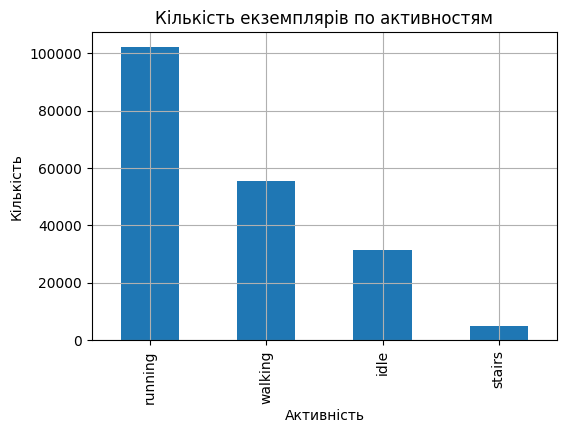

In [168]:
plt.figure(figsize=(6, 4))
activity_counts = devices['Activity'].value_counts()
activity_counts.plot(kind='bar')
plt.title('Кількість екземплярів по активностям')
plt.xlabel('Активність')
plt.ylabel('Кількість')
plt.grid()
plt.show()

In [169]:
grouped_data = devices.groupby('Activity').mean()

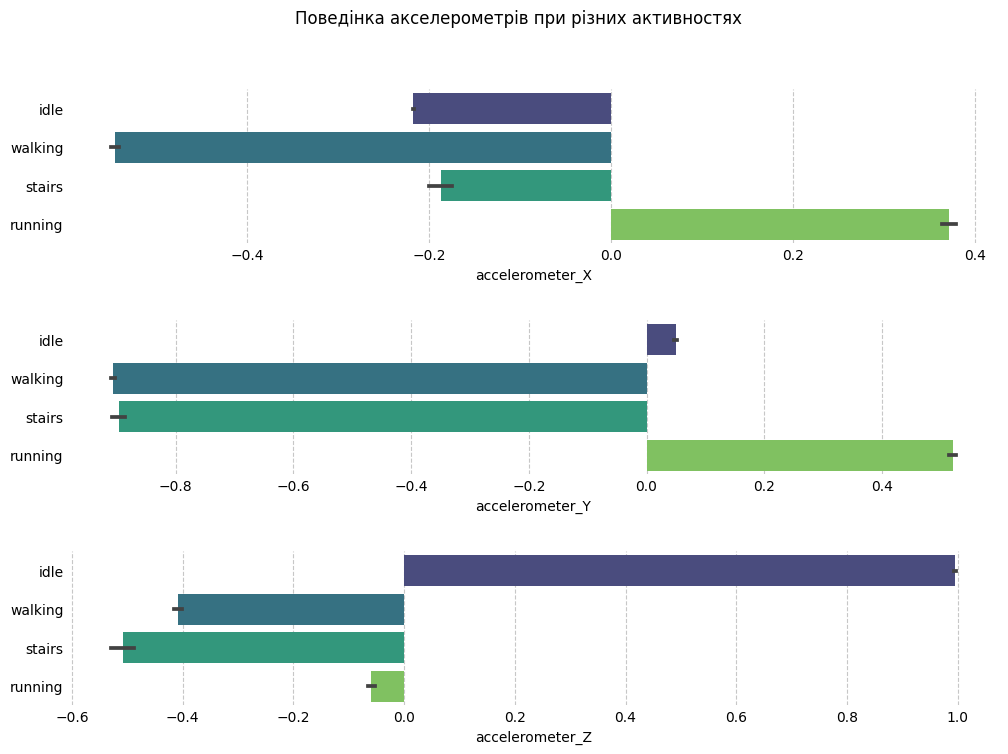

In [170]:
fig, axes = plt.subplots(3, figsize=(12, 8))
fig.suptitle('Поведінка акселерометрів при різних активностях')
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, col in enumerate(devices.columns):
    if col != 'Activity':
        sns.barplot(x=col, y='Activity', data=devices, ax=axes[i], palette='viridis')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('')
        axes[i].set_title('')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].tick_params(axis='both', length=0)
        axes[i].grid(axis='x', linestyle='--', alpha=0.7)
        axes[i].set_axisbelow(True)

plt.show()

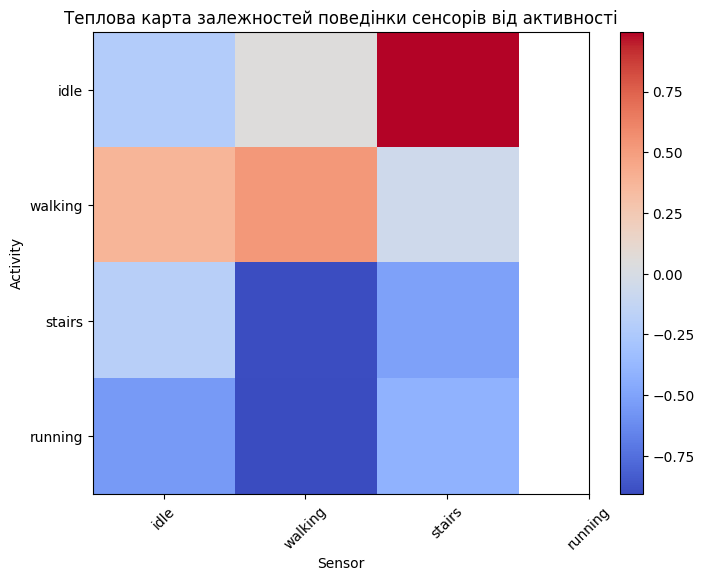

In [171]:
plt.figure(figsize=(8, 6))
plt.imshow(grouped_data, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(activities)), activities, rotation=45)
plt.yticks(range(len(activities)), activities)
plt.xlabel('Sensor')
plt.ylabel('Activity')
plt.title('Теплова карта залежностей поведінки сенсорів від активності')
plt.show()

### Побудова моделей та оцінка

Розбиття масиву даних на тренувальний та тестовий набіри

In [172]:
X = devices.drop('Activity', axis=1)
y = devices['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ПОПЕРЕДЖЕННЯ!!! Від 6 до 15 хвилин!!!!
Виконувати не бажано, код закоментовано, результати наведені нижче
Побудова svm моделі та оцінка її результативності

In [173]:
# svm = SVC()
# svm.fit(X_train, y_train)

# y_pred = svm.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')

# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

Висновок: побудова моделі опорних векторів на сирих даних - дуже ресурсоємна, час виконання - біля 15 хвилин, показники ефективнсті низькі:
Accuracy: 0.8937474248042852
Precision: 0.9003228561183134
Recall: 0.8937474248042852
F1-score: 0.883469491496501

Побудова моделі випадковий ліс та оцінка її результативності

In [174]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9996652245570663
Precision: 0.9996653123277535
Recall: 0.9996652245570663
F1-score: 0.9996648288208538


Висновок: побудована модель випадкового лісу на сирих даних дуже швидка (18с) та з гарними показниками ефективності:
Accuracy: 0.9996652245570663
Precision: 0.9996653123277535
Recall: 0.9996652245570663
F1-score: 0.9996648288208538

## Зчитування з одночасним мануальним побудуванням додаткових ознак

### Підготовка та запис даних

Перевіряємо перелік активностей та кількість записів до кожної з них

In [175]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/data'

activities = listdir(data_folder)

for activity in activities:
    path = join(data_folder, activity)
    frames = listdir(path)
    print(activity, " : ", len(frames))


idle  :  1049
walking  :  1850
stairs  :  165
running  :  3408


Задаємо список нових ознак які буде додано до дата сету

In [176]:
time_domain_features = ['skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z',
                        'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z',
                        'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z',
                        'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']

Будуємо функцію для додавання нових ознак при обробці чанків даних

In [177]:
def get_statistic_features(frame):
    features = []

    # Вычисление статистических признаков для каждой оси акселерометра
    for axis in ['X', 'Y', 'Z']:
        # Skew
        features.append(frame['accelerometer_' + axis].skew())

        # Kurtosis
        features.append(frame['accelerometer_' + axis].kurtosis())

        # Max
        features.append(frame['accelerometer_' + axis].max())

        # Min
        features.append(frame['accelerometer_' + axis].min())

        # Mean
        features.append(frame['accelerometer_' + axis].mean())

        # Standard Deviation
        features.append(frame['accelerometer_' + axis].std())

        # Variance
        features.append(frame['accelerometer_' + axis].var())

        # Median
        features.append(frame['accelerometer_' + axis].median())

        # Index of Maximum
        features.append(frame['accelerometer_' + axis].idxmax())

        # Index of Minimum
        features.append(frame['accelerometer_' + axis].idxmin())

        # Mean Absolute Error (MAE)
        features.append(np.abs(frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean()).mean())

        # Root Mean Squared Error (RMSE)
        features.append(np.sqrt(((frame['accelerometer_' + axis] - frame['accelerometer_' + axis].mean())**2).mean()))

    # Correlation between X and Y axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Y']))

    # Correlation between X and Z axes
    features.append(frame['accelerometer_X'].corr(frame['accelerometer_Z']))

    # Correlation between Y and Z axes
    features.append(frame['accelerometer_Y'].corr(frame['accelerometer_Z']))

    return features

Додаємо функцію процесінгу датасету зі зчитування даних та виклику попередньої фунції

In [178]:
def process_data(data_folder, activities):
    columns = ['activity'] + time_domain_features
    features_list = []

    for activity in activities:
        path = join(data_folder, activity)
        frames = listdir(path)

        for frame_file in frames:
            frame = pd.read_csv(join(path, frame_file))
            features = get_statistic_features(frame)
            features_list.append([activity] + features)

    df = pd.DataFrame(features_list, columns=columns)
    return df

df = process_data(data_folder, activities)
df.shape

(6472, 40)

Записуємо до диску і надалі працюємо вже зі збереженими даними

In [179]:
output_file = 'manual_engeneered_data.csv'
df.to_csv(output_file, index=False)

In [180]:
engeneered_devices = pd.read_csv("manual_engeneered_data.csv")

engeneered_devices.head(10)

,activity,skew_X,skew_Y,skew_Z,kurtosis_X,kurtosis_Y,kurtosis_Z,max_X,max_Y,max_Z,...,idxmin_Z,mae_X,mae_Y,mae_Z,rmse_X,rmse_Y,rmse_Z,corr_XY,corr_XZ,corr_YZ
0,idle,-0.084212,-0.339821,0.320823,0.196325,0.253307,0.031118,0.000968,0.256179,14,...,0.024186,0.000585,9.763555,22,16,0.018175,0.023780,-0.328361,0.114295,-0.069101
1,idle,0.551952,1.169765,0.344765,0.215478,0.260649,0.028389,0.000806,0.260968,18,...,0.030021,0.000901,9.768343,29,19,0.019579,0.029516,-0.059196,-0.029258,-0.554027
2,idle,1.347404,2.822737,0.411803,0.201113,0.269268,0.045578,0.002077,0.265756,16,...,0.018757,0.000352,9.768343,28,16,0.013716,0.018441,0.138932,-0.110456,-0.520717
3,idle,-3.363902,15.513042,0.330400,-0.019154,0.251870,0.059257,0.003511,0.260968,24,...,0.216292,0.046782,9.763555,29,23,0.076125,0.212656,-0.191451,0.138108,-0.922642
4,idle,1.015734,2.831464,0.411803,0.177171,0.263522,0.046057,0.002121,0.265756,28,...,0.018335,0.000336,9.770737,0,28,0.013918,0.018027,0.134814,-0.145677,-0.433550
5,idle,0.107167,0.136352,0.354342,0.177171,0.256658,0.038464,0.001479,0.260968,23,...,0.019600,0.000384,9.770737,0,1,0.015004,0.019270,-0.221111,0.372523,-0.084091
6,idle,0.190750,-0.317546,0.320823,0.196325,0.250593,0.031345,0.000983,0.248997,8,...,0.025403,0.000645,9.761161,16,10,0.019845,0.024976,-0.311080,0.254857,-0.034578
7,idle,1.172114,3.144548,0.344765,0.215478,0.260330,0.025196,0.000635,0.256179,28,...,0.028389,0.000806,9.768343,27,29,0.017728,0.027912,0.060012,-0.030105,-0.603731
8,idle,-0.184708,-0.382724,0.306458,0.210690,0.259851,0.024927,0.000621,0.263362,22,...,0.020561,0.000423,9.768343,3,10,0.016153,0.020216,-0.119603,0.184808,-0.167913
9,idle,0.706060,1.307255,0.344765,0.215478,0.258893,0.028480,0.000811,0.256179,16,...,0.029883,0.000893,9.768343,27,17,0.018771,0.029381,-0.063459,-0.010904,-0.555572


Окремо перевіряємо список ознак

In [181]:
print(engeneered_devices.columns.tolist())

['activity', 'skew_X', 'skew_Y', 'skew_Z', 'kurtosis_X', 'kurtosis_Y', 'kurtosis_Z', 'max_X', 'max_Y', 'max_Z', 'min_X', 'min_Y', 'min_Z', 'mean_X', 'mean_Y', 'mean_Z', 'std_X', 'std_Y', 'std_Z', 'variance_X', 'variance_Y', 'variance_Z', 'median_X', 'median_Y', 'median_Z', 'idxmax_X', 'idxmax_Y', 'idxmax_Z', 'idxmin_X', 'idxmin_Y', 'idxmin_Z', 'mae_X', 'mae_Y', 'mae_Z', 'rmse_X', 'rmse_Y', 'rmse_Z', 'corr_XY', 'corr_XZ', 'corr_YZ']


### Декілька графиків для візуалізації датасету

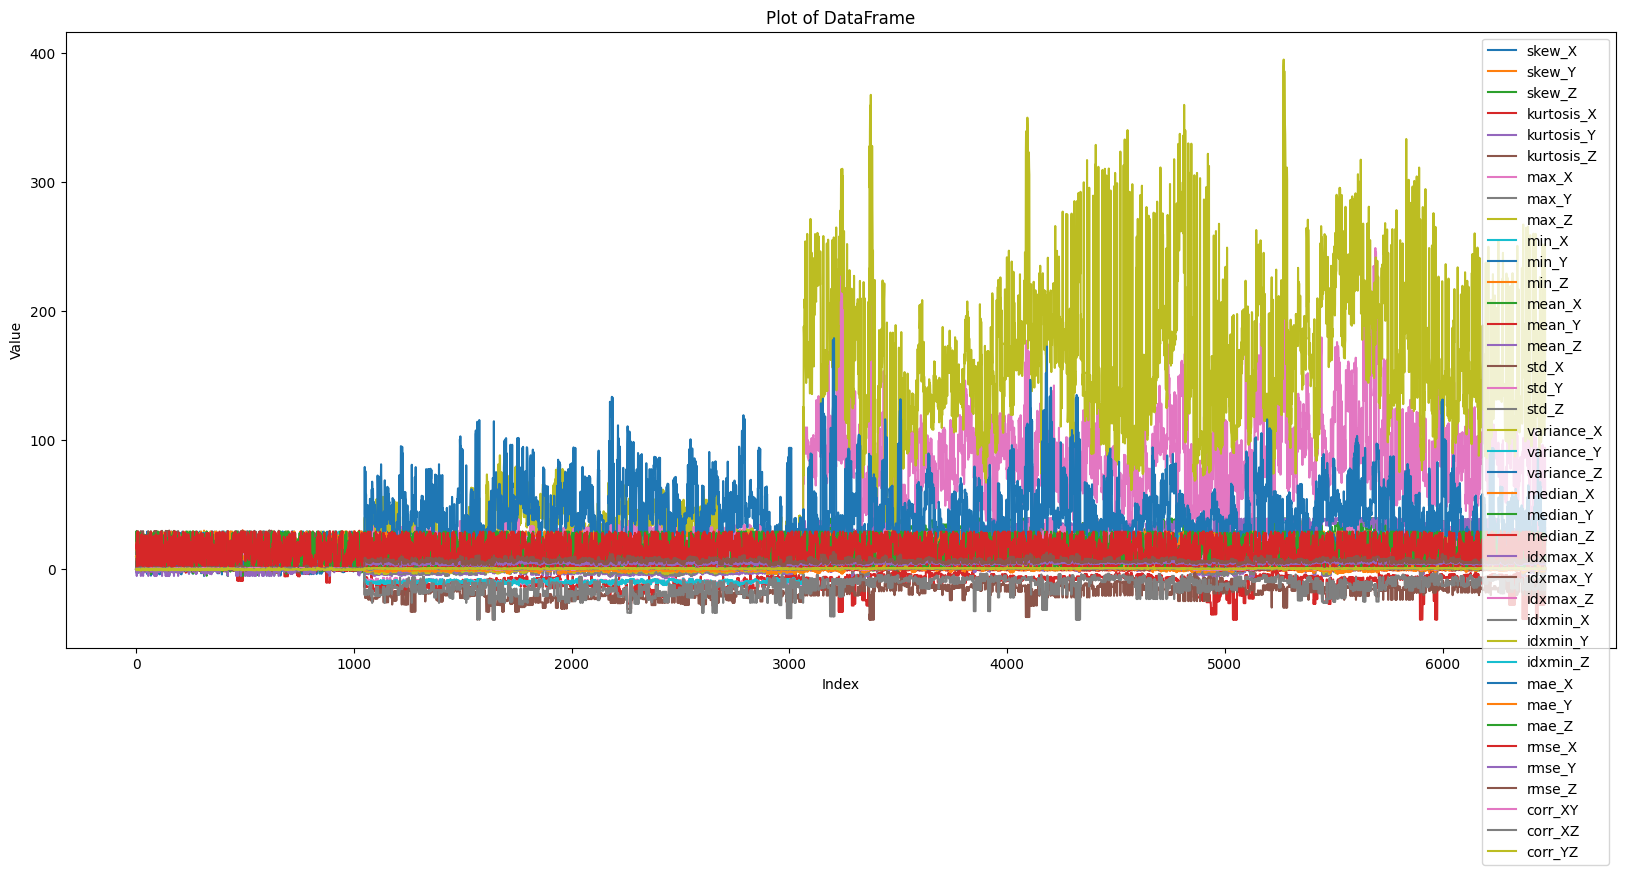

In [182]:

engeneered_devices.plot(figsize=(20, 8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of DataFrame')
plt.show()

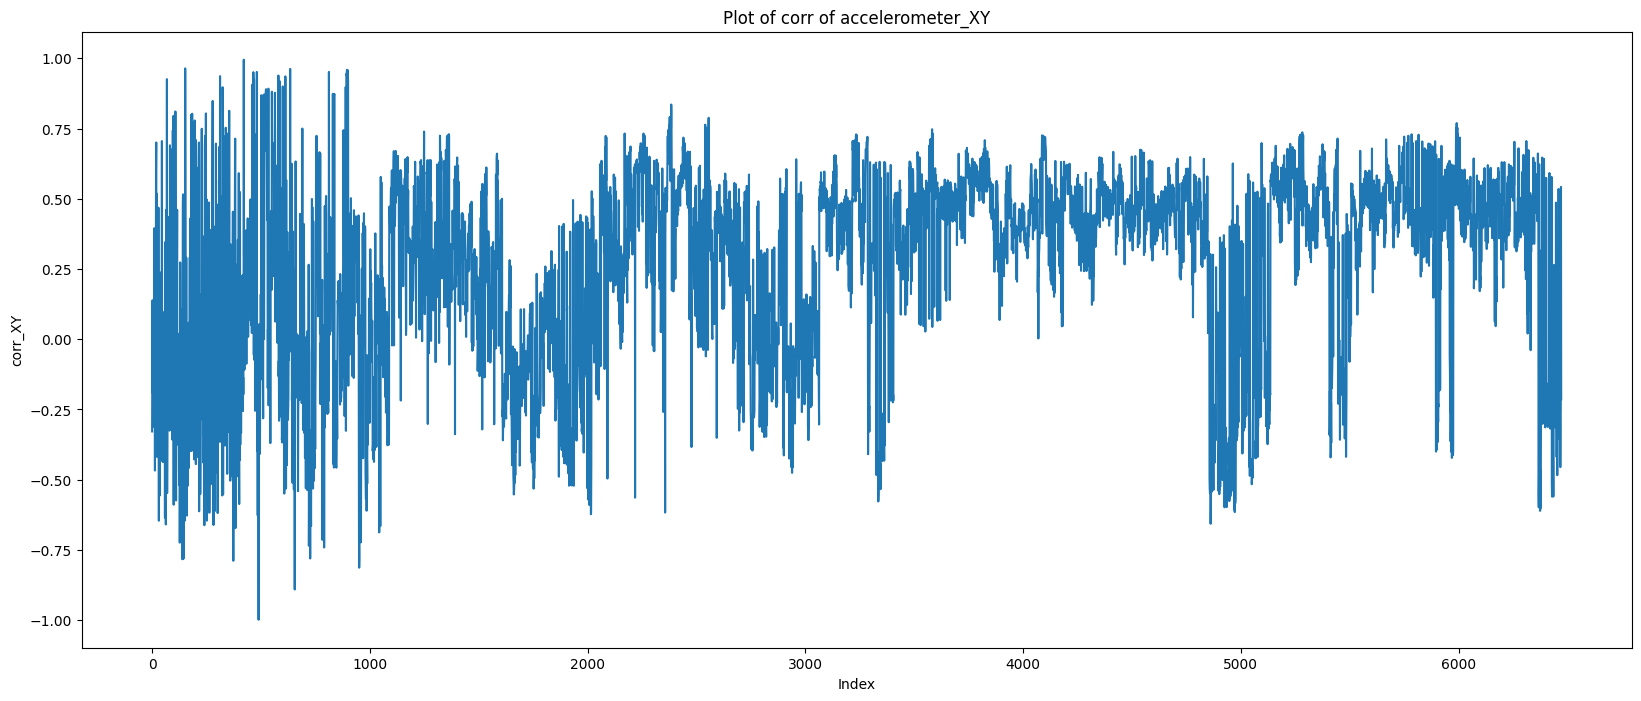

In [184]:
plt.figure(figsize=(20, 8))
plt.plot(engeneered_devices['corr_XY'])
plt.xlabel('Index')
plt.ylabel('corr_XY')
plt.title('Plot of corr of accelerometer_XY')
plt.show()

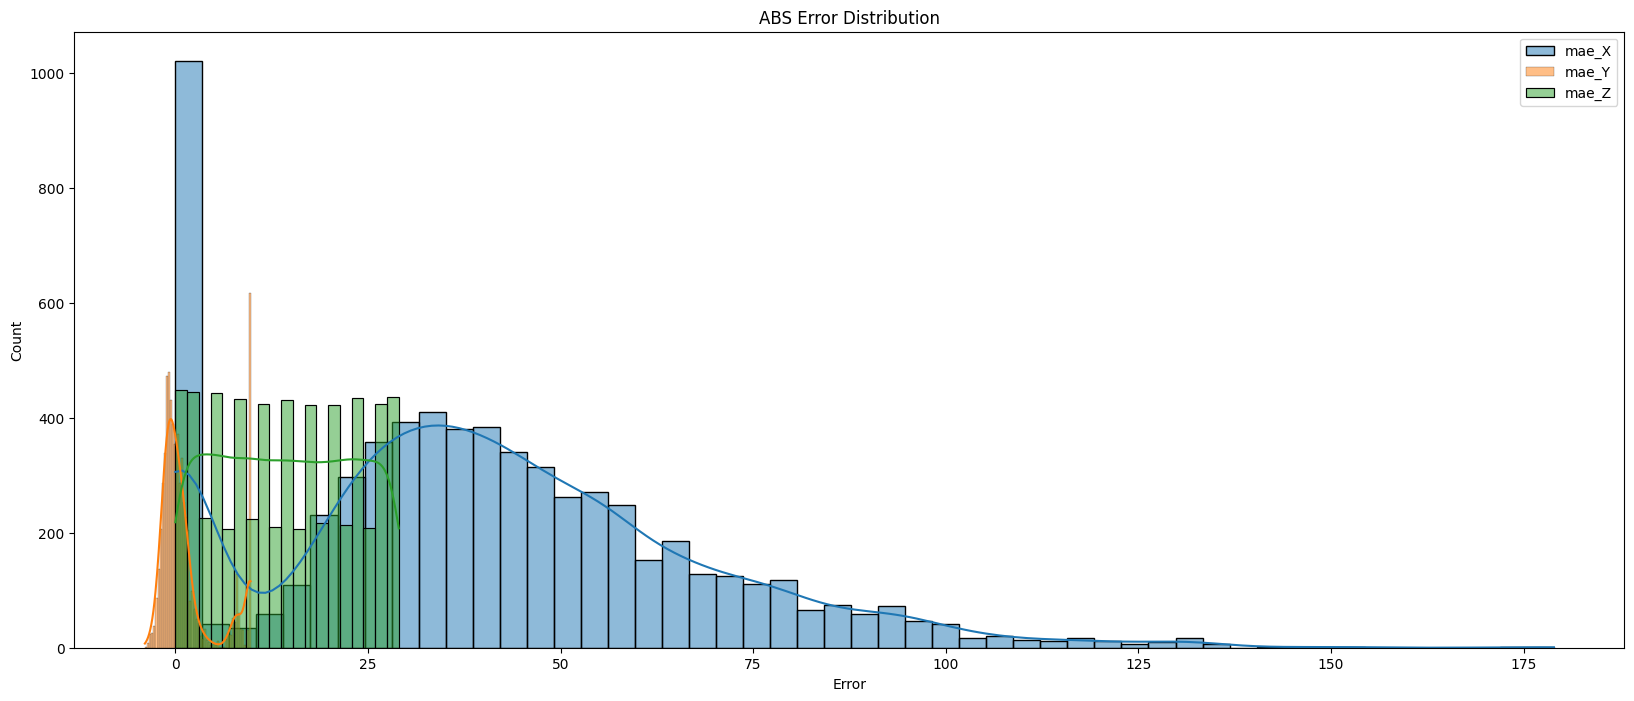

In [185]:
error_cols = ['mae_X', 'mae_Y', 'mae_Z']

# Графік розподілу помилок
plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('ABS Error Distribution')
plt.legend()
plt.show()

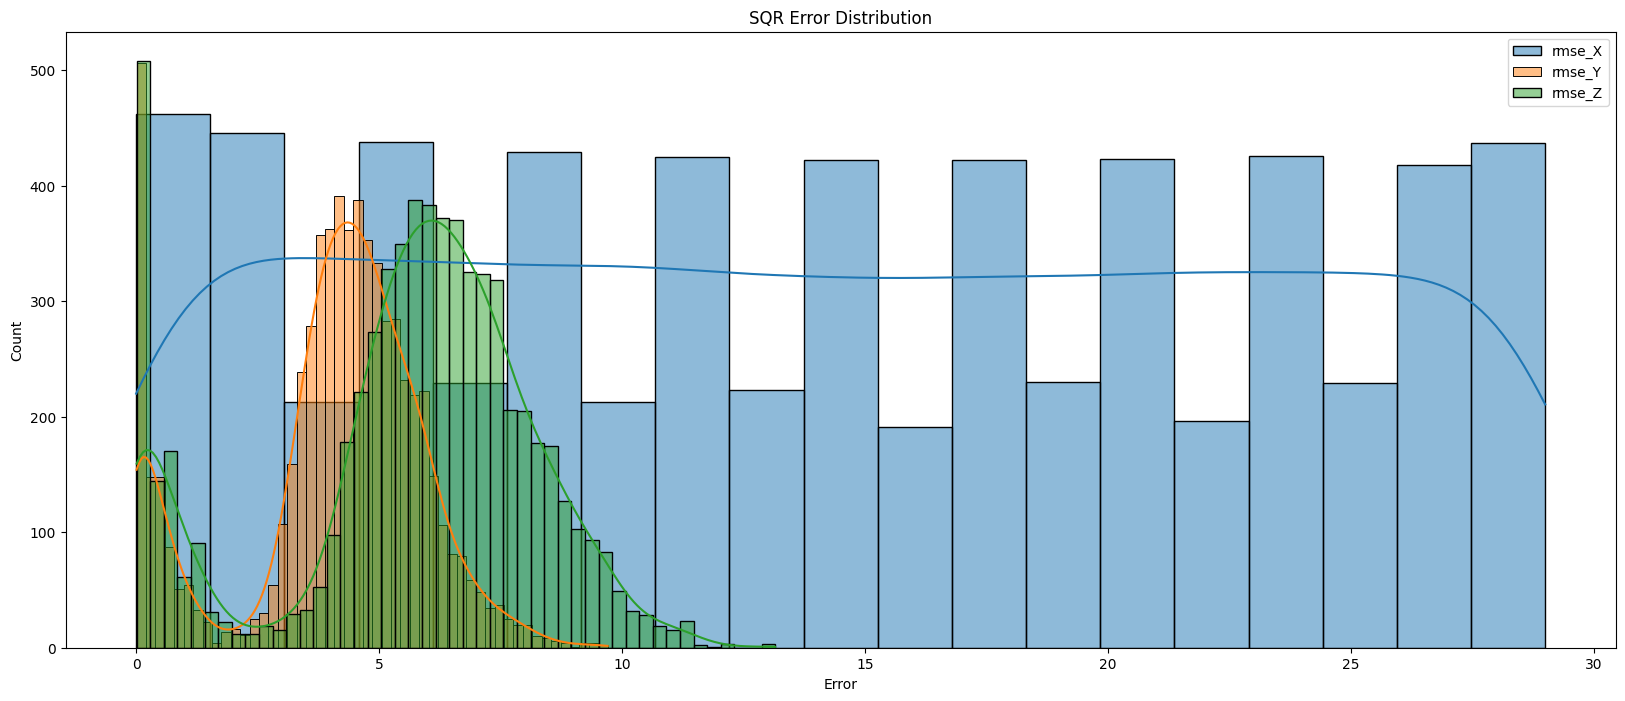

In [186]:
error_cols = ['rmse_X', 'rmse_Y', 'rmse_Z']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Error')
plt.ylabel('Count')
plt.title('SQR Error Distribution')
plt.legend()
plt.show()

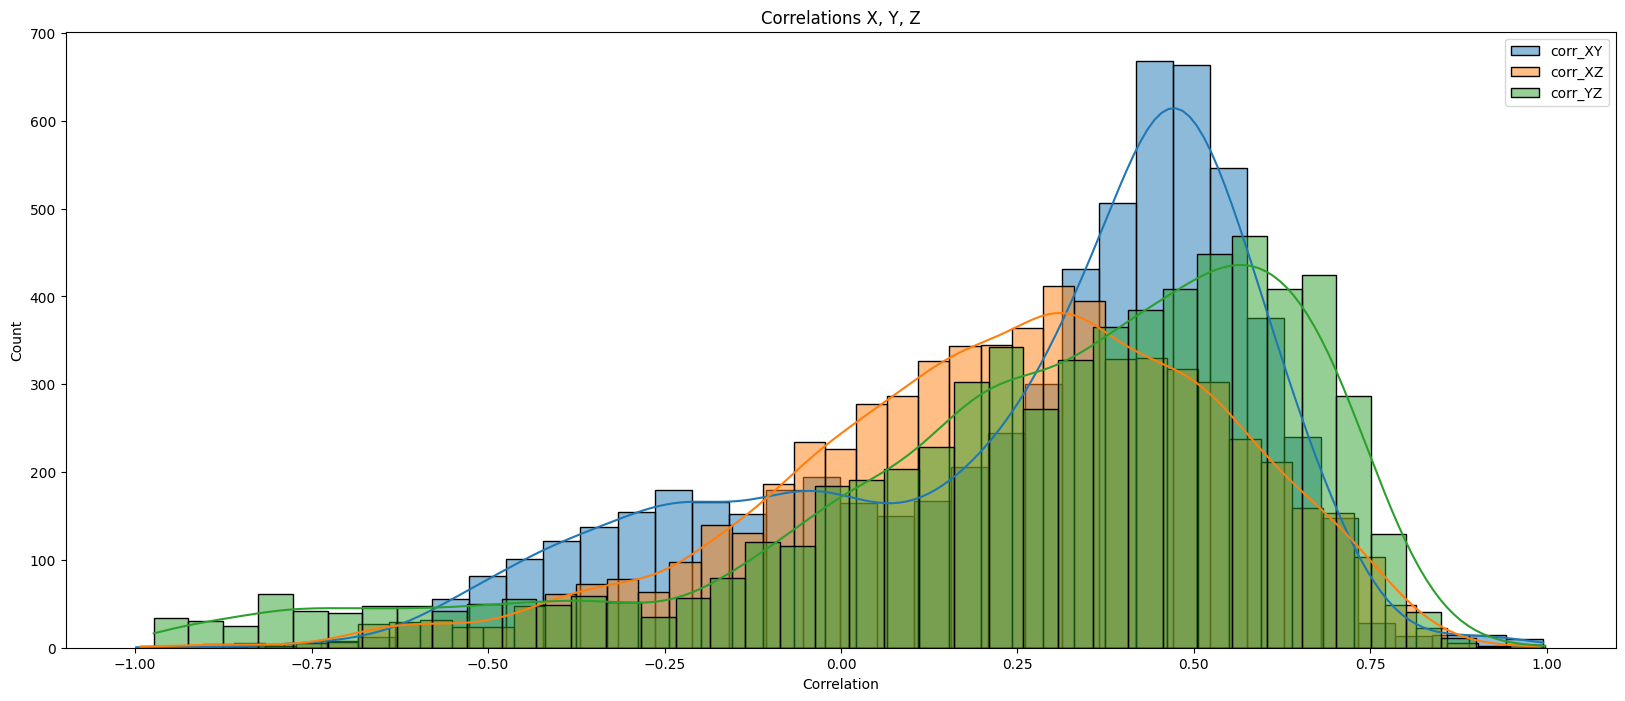

In [187]:
error_cols = ['corr_XY', 'corr_XZ', 'corr_YZ']

plt.figure(figsize=(20, 8))
for col in error_cols:
    sns.histplot(engeneered_devices[col], kde=True, label=col)

plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Correlations X, Y, Z')
plt.legend()
plt.show()

### Побудова моделей та їх аналіз

In [188]:
X = engeneered_devices.drop('activity', axis=1)
y = engeneered_devices['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Побудова нерегулюємих моделей SVM та  RandomForest

In [189]:
# Модель SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("Accuracy (SVM):", accuracy_svm)
print("Precision (SVM):", precision_svm)
print("Recall (SVM):", recall_svm)
print("F1-score (SVM):", f1_svm)

# Модель RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("\nAccuracy (RandomForest):", accuracy_rf)
print("Precision (RandomForest):", precision_rf)
print("Recall (RandomForest):", recall_rf)
print("F1-score (RandomForest):", f1_rf)

Accuracy (SVM): 0.9961389961389961
Precision (SVM): 0.9961904761904762
Recall (SVM): 0.9961389961389961
F1-score (SVM): 0.9959937146646356

Accuracy (RandomForest): 0.9992277992277993
Precision (RandomForest): 0.9992298806314979
Recall (RandomForest): 0.9992277992277993
F1-score (RandomForest): 0.999222380275012


Висновок: побудовані на мануально зінженірених ознаках моделі випадкового лісу та опорних векторів показали високу швидкість (1,7 с на дві моделі) та ефективність 0.995 -0.999

#### Побудова регулюємих моделей SVM та  RandomForest

In [190]:
# Списки параметрів для моделей
svm_params = [{'kernel': 'linear'}, {"C": 10, 'kernel': 'linear'}, {'kernel': 'rbf', 'gamma': 0.1},
              {'kernel': 'rbf', 'gamma': 0.01},  {'kernel': 'poly', 'degree': 2}, {'kernel': 'poly', 'degree': 5}]
rf_params = [{'n_estimators': 100, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 10}, {'n_estimators': 200, 'max_depth': 20},
             {'n_estimators': 200, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 30}, {'n_estimators': 300, 'max_depth': 5}]


In [192]:

# Цикл для навчання та оцінки моделей з різними параметрами
for svm_param in svm_params:
    svm_model = SVC(**svm_param, probability=True)
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
    recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=1)

    f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

    print("\nSVM Parameters:", svm_param)
    print("Accuracy (SVM):", accuracy_svm)
    print("Precision (SVM):", precision_svm)
    print("Recall (SVM):", recall_svm)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, svm_model.predict(X_train), average='weighted'), "test:", f1_svm)




SVM Parameters: {'kernel': 'linear'}
Accuracy (SVM): 0.9961389961389961
Precision (SVM): 0.9961904761904762
Recall (SVM): 0.9961389961389961
Overfitting check F1-score:  train: 0.996699035154143 test: 0.9959937146646356

SVM Parameters: {'C': 10, 'kernel': 'linear'}
Accuracy (SVM): 0.9984555984555985
Precision (SVM): 0.9984639016897081
Recall (SVM): 0.9984555984555985
Overfitting check F1-score:  train: 0.9982524303757226 test: 0.9984335485851658

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.1}
Accuracy (SVM): 0.5305019305019305
Precision (SVM): 0.7517847415521834
Recall (SVM): 0.5305019305019305
Overfitting check F1-score:  train: 1.0 test: 0.3718113023834992

SVM Parameters: {'kernel': 'rbf', 'gamma': 0.01}
Accuracy (SVM): 0.8903474903474904
Precision (SVM): 0.9092439179817821
Recall (SVM): 0.8903474903474904
Overfitting check F1-score:  train: 1.0 test: 0.8871030630828479

SVM Parameters: {'kernel': 'poly', 'degree': 2}
Accuracy (SVM): 0.9706563706563707
Precision (SVM): 0.97325743

In [193]:
for rf_param in rf_params:
    rf_model = RandomForestClassifier(random_state=42, **rf_param)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
    #auc_roc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')
    auc_prc_rf = []
    for i in range(len(rf_model.classes_)):
        class_scores = rf_model.predict_proba(X_test)[:, i]
        class_labels = np.where(y_test == rf_model.classes_[i], 1, 0)
        auc_prc = average_precision_score(class_labels, class_scores)
        auc_prc_rf.append(auc_prc)



    print("\nRandomForest Parameters:", rf_param)
    print("Accuracy (RandomForest):", accuracy_rf)
    print("Precision (RandomForest):", precision_rf)
    print("Recall (RandomForest):", recall_rf)
    #print("AUC-ROC:", auc_roc_rf)
    print("AUC-PRC:", auc_prc_rf)
    print("Overfitting check F1-score: ", "train:", f1_score(y_train, rf_model.predict(X_train), average='weighted'), "test:", f1_rf)


RandomForest Parameters: {'n_estimators': 100, 'max_depth': 10}
Accuracy (RandomForest): 0.9976833976833976
Precision (RandomForest): 0.9977020298736116
Recall (RandomForest): 0.9976833976833976
AUC-PRC: [1.0, 1.0, 0.9981904607573057, 0.9999782624447503]
Overfitting check F1-score:  train: 0.9988287234571451 test: 0.9976329173406658

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 10}
Accuracy (RandomForest): 0.9976833976833976
Precision (RandomForest): 0.9977020298736116
Recall (RandomForest): 0.9976833976833976
AUC-PRC: [1.0, 1.0, 0.9981904607573057, 0.9999854693403081]
Overfitting check F1-score:  train: 0.9988287234571451 test: 0.9976329173406658

RandomForest Parameters: {'n_estimators': 200, 'max_depth': 20}
Accuracy (RandomForest): 0.9992277992277993
Precision (RandomForest): 0.9992298806314979
Recall (RandomForest): 0.9992277992277993
AUC-PRC: [1.0, 1.0, 0.9999999999999999, 1.0]
Overfitting check F1-score:  train: 1.0 test: 0.999222380275012

RandomForest Parameter

Висновок: при побудові декількох варіантів для кожної моделі бачимо що:
- метод опорних векторів  справляється гірше (6 моделей - 1 хв.):
    - на RBF kernel - f1 від 0,3 до 0,9, та спостерігається перенавчання
    - на polynomial kernel  - f1 від 0,94 до 0,95, перенавчання відсутнє
    - найкращі результати у лінійної моделі - f1 від 0,996 до 0,998, перенавчання майже відсутнє
- метод випадкового лісу при різноманітних параметрах показав найбільшу ефективність (6 моделей - 15 сек) - f1 від 0,987 до 0,999, при змінах параметрів спостерігається деяке перенавчання